<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparando-Análise" data-toc-modified-id="Preparando-Análise-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparando Análise</a></span></li><li><span><a href="#Decision-Trees" data-toc-modified-id="Decision-Trees-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Decision Trees</a></span><ul class="toc-item"><li><span><a href="#Dados-de-Treino" data-toc-modified-id="Dados-de-Treino-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Dados de Treino</a></span></li><li><span><a href="#Tunando-Hiperparâmetros" data-toc-modified-id="Tunando-Hiperparâmetros-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Tunando Hiperparâmetros</a></span></li><li><span><a href="#Dados-de-Teste" data-toc-modified-id="Dados-de-Teste-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Dados de Teste</a></span></li><li><span><a href="#Shifting-Images" data-toc-modified-id="Shifting-Images-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Shifting Images</a></span></li></ul></li><li><span><a href="#SGD-Classifier" data-toc-modified-id="SGD-Classifier-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SGD Classifier</a></span><ul class="toc-item"><li><span><a href="#Dados-de-Treino" data-toc-modified-id="Dados-de-Treino-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dados de Treino</a></span></li><li><span><a href="#Tunando-Hiperparâmetros" data-toc-modified-id="Tunando-Hiperparâmetros-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Tunando Hiperparâmetros</a></span></li><li><span><a href="#Dados-de-Teste" data-toc-modified-id="Dados-de-Teste-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Dados de Teste</a></span></li><li><span><a href="#Shifting-Images" data-toc-modified-id="Shifting-Images-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Shifting Images</a></span></li></ul></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Random Forest</a></span><ul class="toc-item"><li><span><a href="#Dados-de-Treino" data-toc-modified-id="Dados-de-Treino-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Dados de Treino</a></span></li><li><span><a href="#Tunando-Hiperparâmetros" data-toc-modified-id="Tunando-Hiperparâmetros-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Tunando Hiperparâmetros</a></span></li></ul></li></ul></div>

Este notebook tem por objetivo comparar diferentes algoritmos utilizados em problemas de classificação através do dataset MNIST. Com isso, será possível avaliar a performance de cada um deles, avaliando, analisando e identificando importantes parâmetros como tempo de processamento e complexidade dos modelos.

## Preparando Análise

In [1]:
# Importando bibliotecas para análise e preparação dos dados
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from random import randint
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.interpolation import shift

# Importando bibliotecas para treinamento de algoritmos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

# Importando bibliotecas para avaliação de performance
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV

In [45]:
# Definindo funções e variáveis

def create_dataset():
    """
    Função para criação (primeira vez) de um dataset vazio para armazenar acurácias
    """
    dataset_cols = ['acc_train', 'acc_train_cv', 'acc_train_scaled', 'acc_test'
                   ,'acc_test_scaled', 'acc_test_grid', 'acc_test_shifted']
    dict_accs = {}
    dataset_accs = pd.DataFrame({})
    for col in dataset_cols:
        dataset_accs[col] = []
    return dataset_accs, dict_accs

def load_dataset():
    """
    Função responsável por ler dataset já criado (a partir da primeira vez)
    
    Output:
        DataFrame
    """
    path = 'C:/Users/thiagoPanini/data-science-repos/coursera-stanford/'
    root = 'machine-learning/notations/semana-5/python-programs/'
    file_name = 'dataset_accs.csv'
    
    return pd.read_csv(path+root+file_name)

def save_dataset(df):
    """
    Função responsável por salvar o dataset a partir da primeira análise
    
    Input:
        DataFrame a ser salvo
    """
    df.to_csv('dataset_accs.csv', index=False)
    
def display_scores(scores):
    """
    Função para mostrar scores da validação cruzada
    """
    print(f'Scores: {scores}')
    print(f'Média: {scores.mean():.4f}')
    print(f'Desvio Padrão: {scores.std():.4f}')
    
def prepare_mnist():
    """
    Função responsável por importar e realizar todos os procedimentos preparatórios
    no dataset MNIST.
    
    Output: X_train, y_train, X_test, y_test
    """
    
    # Download das bibliotecas necessárias
    from sklearn.datasets import fetch_mldata
    import numpy as np
    
    # Download e separação do dataset
    mnist = fetch_mldata('MNIST original')
    X, y = mnist['data'], mnist['target']
    
    # Separando dados de treino e de teste
    X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]
    
    # Embaralhando dados
    shuffle_index = np.random.permutation(X_train.shape[0])
    X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
    
    # Retornando dados
    return X_train, y_train, X_test, y_test

def data_scaled(X_train, X_test):
    """
    Função responsável por aplicar padronização no conjunto de dados
    
    Input: X_train, X_test -> dados brutos
    Output: X_train_scaled, X_test_scaled -> dados padronizados
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    
    return X_train_scaled, X_test_scaled

def shift_image(image, dx, dy):
    """
    Função responsável por deslocar imagens do dataset em determinada direção
    
    Input: 
        image (registro do dataset X_train)
        dx, dy (deslocamentos em x e y)
    Output:
        shifted_image (imagem deslocada)
    """
    image = image.reshape((28, 28))
    shift_image = shift(image, [dy, dx], cval=0, mode='constant')
    return shift_image.reshape([-1])

def augment_data(X_train, y_train):
    """
    Função para deslocar imagens do dataset em todas as direções
    
    Input:
        X_train, y_train (dados brutos de entrada)
    Output:
        X_train_augmented, y_train_augmented (dados deslocados e embaralhados em formato de array)
    """
    X_train_augmented = [image for image in X_train]
    y_train_augmented = [label for label in y_train]
    
    for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
        for image, label in zip(X_train, y_train):
            X_train_augmented.append(shift_image(image, dx, dy))
            y_train_augmented.append(label)
    
    X_train_augmented = np.array(X_train_augmented)
    y_train_augmented = np.array(y_train_augmented)
    
    shuffle_idx = np.random.permutation(len(X_train_augmented))
    X_train_augmented = X_train_augmented[shuffle_idx]
    y_train_augmented = y_train_augmented[shuffle_idx]
    
    return X_train_augmented, y_train_augmented

def plot_mnist(X, cmap='binary'):
    """
    Função para plotar graficamente dígitos aleatórios do dataset MNIST
    """
    some_digit = X[randint(0, X.shape[0])]
    some_digit_reshaped = some_digit.reshape(28, 28)
    plt.imshow(some_digit_reshaped, cmap=cmap, interpolation='nearest')
    plt.axis('off')
    plt.show()

def plot_data_augmented(X):
    """
    Função responsável por plotar graficamente imagens deslocadas do dataset
    """
    image = X[randint(0, X.shape[0])]
    shifted_image_down = shift_image(image, 0, 5)
    shifted_image_left = shift_image(image, -5, 0)
    shifted_image_up = shift_image(image, 0, -5)
    shifted_image_right = shift_image(image, 5, 0)
    
    # Criando figure e plotando gráficos
    plt.figure(figsize=(12, 3))
    plt.subplot(151)
    plt.title('Original', fontsize=14)
    plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
    plt.subplot(152)
    plt.title('Shifted down', fontsize=14)
    plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
    plt.subplot(153)
    plt.title('Shifted left', fontsize=14)
    plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
    plt.subplot(154)
    plt.title('Shifted up', fontsize=14)
    plt.imshow(shifted_image_up.reshape(28, 28), interpolation="nearest", cmap="Greys")
    plt.subplot(155)
    plt.title('Shifted right', fontsize=14)
    plt.imshow(shifted_image_right.reshape(28, 28), interpolation="nearest", cmap="Greys")
    
    plt.show()

# Explorando Dados

Com a definição das funções e importação das bibliotecas necessárias, os códigos a seguir terão como objetivo mostrar um pouco mais sobre o dataset MNIST, como o download e plotagens dos dados.

In [3]:
# Realizando o download e a preparação dos dados
X_train, y_train, X_test, y_test = prepare_mnist()

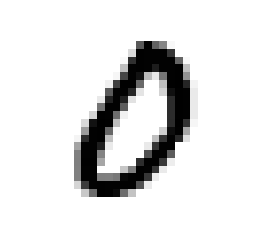

In [4]:
# Plotando dados
plot_mnist(X_train)

In [5]:
# Verificando dimensões
print(f'Dimensões de X_train: {X_train.shape}')
print(f'Dimensões de y_train: {y_train.shape}')
print()
print(f'Dimensões de X_test: {X_test.shape}')
print(f'Dimensões de y_test: {y_test.shape}')

Dimensões de X_train: (60000, 784)
Dimensões de y_train: (60000,)

Dimensões de X_test: (10000, 784)
Dimensões de y_test: (10000,)


Trata-se de um dataset com imagens de dimensões 28x28 (totalizando 784 features). Os dados de treino possuem 60000 registros, enquanto os dados de teste são compostos por 10000 registros.

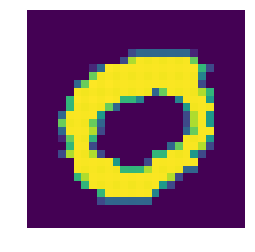

In [6]:
# Plotagem diferenciada
plot_mnist(X_train, cmap='viridis')

## Decision Trees

O primeiro algoritmo utilizado será o ```DecisionTrees```: [Doc](https://scikit-learn.org/stable/modules/tree.html)

In [7]:
# Como é a primeira análise, temos que criar um dataset vazio
dataset_accs, dict_accs_tree = create_dataset()

In [8]:
# Dataset criado
dataset_accs

,acc_train,acc_train_cv,acc_train_scaled,acc_test,acc_test_scaled,acc_test_grid,acc_test_shifted


In [9]:
# Dicionário criado para armazenar acurácias
dict_accs_tree

{}

### Dados de Treino

In [10]:
# Criando classificador
dtree = DecisionTreeClassifier()

# Treinando modelo (sem transformações)
dtree.fit(X_train, y_train)

# Avaliando acurácia
train_pred = dtree.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
print(f'Acurácia do Decision Trees com dados de treino: {train_acc:.4f}')

# Salvando dados
dict_accs_tree['acc_train'] = round(train_acc, 4)

Acurácia do Decision Trees com dados de treino: 1.0000


Será um tremendo overfitting? Sempre é preciso desconfiar de uma grande acurácia nos dados de treino. Para verificar se realmente há a presença de overfitting, devemos aplicar o ```cross_validation```.

In [11]:
# Aplicando validação cruzada
tree_scores = cross_val_score(dtree, X_train, y_train,
                             cv=3, scoring='accuracy')
display_scores(tree_scores)

# Salvando dados
dict_accs_tree['acc_train_cv'] = round(tree_scores.mean(), 4)

Scores: [0.86182763 0.86124306 0.86192929]
Média: 0.8617
Desvio Padrão: 0.0003


A diminuição da acurácia através da aplicação do ```cross validation``` mostra que realmente o modelo ```DecisionTrees``` é muito sensível ao overfitting.

Na tentativa de melhorar essa performance, vamos aplicar um processo de ```padronização``` nos dados.

In [12]:
# Padronizando dados
X_train_scaled, X_test_scaled = data_scaled(X_train, X_test)

# Realizando um novo treinamento
dtree.fit(X_train_scaled, y_train)

# Verificando nova acurácia com cross validation
tree_scores_scaled = cross_val_score(dtree, X_train_scaled, y_train,
                                    cv=3, scoring='accuracy')

# Comunicando resultados
display_scores(tree_scores_scaled)

# Salvando dados
dict_accs_tree['acc_train_scaled'] = round(tree_scores_scaled.mean(), 4)

C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Scores: [0.85972805 0.86089304 0.8606791 ]
Média: 0.8604
Desvio Padrão: 0.0005


Não houve alterações significativas. Inclusive foi identificado um decréscimo mínimo na acurácia.

Assim, é possível concluir que o modelo ```DecisionTrees``` não é sensível a padronização dos dados.

### Tunando Hiperparâmetros

In [13]:
# Definindo parâmetros para Decision Trees
param_grid_tree = [
    {
     'criterion': ['gini', 'entropy'],
     'min_samples_split': [2, 10, 20],
     'max_depth': [None, 5, 10, 15],
     'min_samples_leaf': [1, 5, 10]
     #'max_leaf_nodes': [None, 5, 10, 20]
    }
]

# Criando classificador
dtree = DecisionTreeClassifier()

# Treinando e procurando a melhor combinação
grid_search_tree = GridSearchCV(dtree, param_grid_tree, cv=3, 
                           scoring='accuracy', verbose=3)

grid_search_tree.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, score=0.8591781643671266, total=  21.0s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.1s remaining:    0.0s


[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, score=0.8609430471523576, total=  19.5s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.9s remaining:    0.0s


[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, score=0.8630794619192879, total=  21.2s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10, score=0.860877824435113, total=  21.0s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10, score=0.8580429021451073, total=  19.3s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10, score=0.8612291843776566, total=  21.0s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=20 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=20, score=0.8565286942611477, total=  20.9s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=20 
[CV]  c

[CV]  criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=20, score=0.6674501175176276, total=   6.6s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=2 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=2, score=0.6662667466506699, total=   6.4s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=2 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=2, score=0.6806340317015851, total=   6.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=2 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=2, score=0.6674501175176276, total=   6.3s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=10 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=10, score=0.6662667466506699, total=   6.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=10 
[CV]  criterion=gini, max_depth=

[CV]  criterion=gini, max_depth=15, min_samples_leaf=1, min_samples_split=20, score=0.8575284943011398, total=  14.7s
[CV] criterion=gini, max_depth=15, min_samples_leaf=1, min_samples_split=20 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=1, min_samples_split=20, score=0.8569928496424821, total=  14.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=1, min_samples_split=20 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=1, min_samples_split=20, score=0.8590288543281492, total=  14.2s
[CV] criterion=gini, max_depth=15, min_samples_leaf=5, min_samples_split=2 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=5, min_samples_split=2, score=0.863377324535093, total=  14.3s
[CV] criterion=gini, max_depth=15, min_samples_leaf=5, min_samples_split=2 
[CV]  criterion=gini, max_depth=15, min_samples_leaf=5, min_samples_split=2, score=0.8596929846492325, total=  13.6s
[CV] criterion=gini, max_depth=15, min_samples_leaf=5, min_samples_split=2 
[CV]  criterion=gini, max_depth

[CV]  criterion=entropy, max_depth=None, min_samples_leaf=10, min_samples_split=10, score=0.8647770445910817, total=  17.8s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=10, min_samples_split=10 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=10, min_samples_split=10, score=0.8603430171508576, total=  17.9s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=10, min_samples_split=10 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=10, min_samples_split=10, score=0.8646296944541682, total=  18.3s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=10, min_samples_split=20 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=10, min_samples_split=20, score=0.8647270545890822, total=  17.6s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=10, min_samples_split=20 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=10, min_samples_split=20, score=0.8613430671533576, total=  17.5s
[CV] criterion=entropy, max_depth=None, min_samp

[CV]  criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=20, score=0.8563784567685153, total=  16.3s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=2 
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=2, score=0.862127574485103, total=  15.6s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=2 
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=2, score=0.8565928296414821, total=  15.5s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=2 
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=2, score=0.8592288843326499, total=  15.8s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=10 
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=10, score=0.8622275544891022, total=  15.7s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=10 
[C

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=10, score=0.8620931046552328, total=  18.5s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=10 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=10, score=0.8643796569485422, total=  18.7s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=20 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=20, score=0.8645270945810838, total=  17.9s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=20 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=20, score=0.8612930646532326, total=  18.4s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=20 
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=10, min_samples_split=20, score=0.8642296344451668, total=  18.0s


[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed: 50.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 10, 20], 'max_depth': [None, 5, 10, 15], 'min_samples_leaf': [1, 5, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [15]:
# Verificando os melhores parâmetros
grid_search_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_leaf': 5,
 'min_samples_split': 10}

In [16]:
# Verificando o melhor score
grid_search_tree.best_score_

0.8695

In [17]:
dataset_accs

,acc_train,acc_train_cv,acc_train_scaled,acc_test,acc_test_scaled,acc_test_grid,acc_test_shifted


In [19]:
dict_accs_tree

{'acc_train': 1.0, 'acc_train_cv': 0.8617, 'acc_train_scaled': 0.8604}

In [18]:
m = grid_search_tree.best_estimator_
p = m.predict(X_test)
accuracy_scorecore(y_test, p)

0.8878

### Dados de Teste

In [39]:
# Calculando acurácia nos dados de teste
dtree.fit(X_train, y_train)
pred_test = dtree.predict(X_test)

acc_test = accuracy_score(y_test, pred_test)
print(f'Acurácia nos dados de teste: {acc_test:.4f}')

# Salvando valores
dict_accs_tree['acc_test'] = round(acc_test, 4)

Acurácia nos dados de teste: 0.8800


Realizando uma comparação com a primeira acurácia obtida nos dados de treino, percebe-se que saímos de incríveis (e enganosos) 100% de acurácia para 87,67%.

In [22]:
# Tentativas de melhora: padronização nos dados
X_train_scaled, X_test_scaled = data_scaled(X_train, X_test)

dtree.fit(X_train_scaled, y_train)
pred_test_scaled = dtree.predict(X_test_scaled)

acc_test_scaled = accuracy_score(y_test, pred_test_scaled)
print(f'Acurácia nos dados de teste após padronização: {acc_test_scaled:.4f}')

# Salvando resultado
dict_accs_tree['acc_test_scaled'] = round(acc_test_scaled, 4)

C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Acurácia nos dados de teste após padronização: 0.6226


Um resultado bem aquém do esperado, provando mais uma vez que o algoritmo ```Decision Trees``` não é sensível à padronização.

In [29]:
# Verificação nos dados de teste com os melhores parâmetros (GridSearchCV)
dtree_final = grid_search_tree.best_estimator_

# Treinando modelo e verificando
dtree_final.fit(X_train, y_train)
pred_test = dtree_final.predict(X_test)
acc_test = accuracy_score(y_test, pred_test)

# Comunicando resultado
print(f'Acurácia nos dados de teste com os melhores parâmetros: {acc_test:.4f}')

# Salvando resultados
dict_accs_tree['acc_test_grid'] = round(acc_test, 4)

Acurácia nos dados de teste com os melhores parâmetros: 0.8890


Houve um ganho de mais de 1% de acurácia através da aplicação do ```GridSearchCV```, o que pode ser considerado excelente! Porém ainda há espaço para mais aprimoramento.

### Shifting Images

Este procedimento é um tanto quanto comum em problemas de classificação utilizando imagens. Com ele, é possível aumentar o conjunto de dados de treinamento através do deslocamento de pixels em alguma direção.

In [25]:
# Retornando novo dataset com imagens deslocadas
X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

In [26]:
# Verificando novas dimensões obtidas
print(f'Dimensões de X_train: {X_train.shape}')
print(f'Dimensões de y_train: {y_train.shape}')
print()
print(f'Dimensões de X_train_augmented: {X_train_augmented.shape}')
print(f'Dimensões de y_train_augmented: {y_train_augmented.shape}')

Dimensões de X_train: (60000, 784)
Dimensões de y_train: (60000,)

Dimensões de X_train_augmented: (300000, 784)
Dimensões de y_train_augmented: (300000,)


Percebe-se que houve um aumento na quantidade de linhas dos conjuntos de treino.

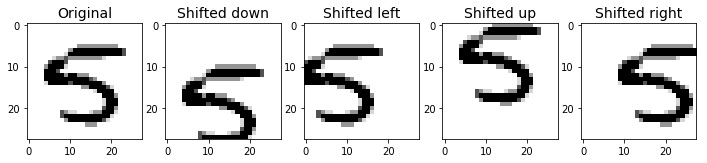

In [28]:
# Plotando gráficos
plot_data_augmented(X_train)

In [32]:
# Realizando o treinamento com novos dados adquiridos
dtree_final = grid_search_tree.best_estimator_

dtree_final.fit(X_train_augmented, y_train_augmented)

# Predizendo valores
y_pred = dtree_final.predict(X_test)
y_acc = accuracy_score(y_test, y_pred)

# Comunicando resultados
print(f'Acurácia após transformação dos dados: {y_acc:.4f}')

Acurácia após transformação dos dados: 0.9211


In [37]:
# Salvando resultados
dict_accs_tree['acc_test_shifted'] = round(y_acc, 4)

In [40]:
# Verificando dados salvos até o momento
dict_accs_tree

{'acc_test': 0.88,
 'acc_test_grid': 0.889,
 'acc_test_scaled': 0.6226,
 'acc_test_shifted': 0.9211,
 'acc_train': 1.0,
 'acc_train_cv': 0.8617,
 'acc_train_scaled': 0.8604}

In [34]:
dataset_accs

,acc_train,acc_train_cv,acc_train_scaled,acc_test,acc_test_scaled,acc_test_grid,acc_test_shifted


In [42]:
# Transformando dados em um objeto DataFrame
dataset_accs = dataset_accs.append(dict_accs_tree, ignore_index=True)
dataset_accs

,acc_train,acc_train_cv,acc_train_scaled,acc_test,acc_test_scaled,acc_test_grid,acc_test_shifted
0,1.0,0.8617,0.8604,0.88,0.6226,0.889,0.9211


In [43]:
# Salvando dados
save_dataset(dataset_accs)

Em resumo, alguns pontos podem ser levantados sobre o algoritimo ```Decision Tree``` na classificação de digitos manuscritos contidos no dataset MNIST:
    - As Árvores de Decisão são muito suscetíveis a Overfitting;
    - Padronização nos dados não melhoram a performance do algoritmo;
    - A acurácia final (após o deslocamento das imagens) é relativamente baixa.

## SGD Classifier

O segundo algoritmo utilizado será o ```SGDClassifier```. [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) 

In [46]:
# Lendo dataset
dataset_accs = load_dataset()
dataset_accs

,acc_train,acc_train_cv,acc_train_scaled,acc_test,acc_test_scaled,acc_test_grid,acc_test_shifted
0,1.0,0.8617,0.8604,0.88,0.6226,0.889,0.9211


In [48]:
# Dicionário criado para armazenar acurácias
dict_accs_sgd = {}

### Dados de Treino

In [49]:
# Criando classificadoor
sgd_clf = SGDClassifier()

# Treinando modelo
sgd_clf.fit(X_train, y_train)

# Predizendo
train_pred = sgd_clf.predict(X_train)

# Acurácia
acc_train = accuracy_score(y_train, train_pred)

# Comunicando resultados
print(f'Acurácia obtida com SGD Classifier nos dados de treino: {acc_train:.4f}')

# Salvando resultados
dict_accs_sgd['acc_train'] = round(acc_train, 4)

C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Acurácia obtida com SGD Classifier nos dados de treino: 0.8825


Aplicando ```cross validation``` para verificar a presença de overfitting.

In [50]:
# Aplicando validação cruzada
sgd_scores = cross_val_score(sgd_clf, X_train, y_train,
                            cv=3, scoring='accuracy')

display_scores(sgd_scores)

# Salvando dados
dict_accs_sgd['acc_train_cv'] = round(sgd_scores.mean(), 4)

C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\thiagoPan

Scores: [0.87342531 0.87849392 0.85142771]
Média: 0.8678
Desvio Padrão: 0.0117


A queda na performance não foi significativa, indicando assim que o algoritmo de Classificação Stocástica não é tão suscetível ao overfitting. Ainda há espaços para melhorias através da padronização.

In [52]:
# Aplicando a padronização dos dados
X_train_scaled, X_test_scaled = data_scaled(X_train, X_test)

# Realizando novo treinamento e avaliação
sgd_clf.fit(X_train_scaled, y_train)
scaled_scores = cross_val_score(sgd_clf, X_train_scaled, y_train,
                               cv=3, scoring='accuracy')
display_scores(scaled_scores)

# Salvando dados
dict_accs_sgd['acc_train_scaled'] = round(scaled_scores.mean(), 4)

C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 a

Scores: [0.90696861 0.91109555 0.91233685]
Média: 0.9101
Desvio Padrão: 0.0023


Houve uma significativa melhora na performance do algoritmo, indicando que a padronização dos dados pode ser algo bem interessante para modelos treinados com ```SGD Classifier```

### Tunando Hiperparâmetros

In [53]:
# Aplicando GridSearchCV
from sklearn.model_selection import GridSearchCV

# Definindo parâmetros para Decision Trees
param_grid_sgd = [
    {
        'loss': ['hinge', 'perceptron', 'log'],
        'penalty': ['l1', 'l2'],
        'alpha': np.linspace(0.0001, 0.01, 10),
        'learning_rate': ['optimal']
    }
    
]

# Criando classificador
sgd_clf = SGDClassifier()

# Treinando e procurando a melhor combinação
grid_search = GridSearchCV(sgd_clf, param_grid_sgd, cv=3, 
                           scoring='accuracy', verbose=4)
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] alpha=0.0001, learning_rate=optimal, loss=hinge, penalty=l1 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=hinge, penalty=l1, score=0.9016696660667867, total=  12.1s
[CV] alpha=0.0001, learning_rate=optimal, loss=hinge, penalty=l1 .....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s
C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=hinge, penalty=l1, score=0.9058452922646132, total=  12.2s
[CV] alpha=0.0001, learning_rate=optimal, loss=hinge, penalty=l1 .....


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.7s remaining:    0.0s
C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=hinge, penalty=l1, score=0.9046857028554283, total=  14.1s
[CV] alpha=0.0001, learning_rate=optimal, loss=hinge, penalty=l2 .....


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   39.1s remaining:    0.0s
C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=hinge, penalty=l2, score=0.907118576284743, total=   4.2s
[CV] alpha=0.0001, learning_rate=optimal, loss=hinge, penalty=l2 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=hinge, penalty=l2, score=0.9108455422771139, total=   4.4s
[CV] alpha=0.0001, learning_rate=optimal, loss=hinge, penalty=l2 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=hinge, penalty=l2, score=0.9110366554983248, total=   3.7s
[CV] alpha=0.0001, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.9005698860227954, total=  10.1s
[CV] alpha=0.0001, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.9053452672633632, total=   8.2s
[CV] alpha=0.0001, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.9017852677901685, total=   7.6s
[CV] alpha=0.0001, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.9063687262547491, total=   2.7s
[CV] alpha=0.0001, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.9107955397769888, total=   2.6s
[CV] alpha=0.0001, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.9110366554983248, total=   2.5s
[CV] alpha=0.0001, learning_rate=optimal, loss=log, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=log, penalty=l1, score=0.9015696860627874, total=   8.8s
[CV] alpha=0.0001, learning_rate=optimal, loss=log, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=log, penalty=l1, score=0.9058952947647383, total=   8.8s
[CV] alpha=0.0001, learning_rate=optimal, loss=log, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=log, penalty=l1, score=0.9036355453317998, total=   8.8s
[CV] alpha=0.0001, learning_rate=optimal, loss=log, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=log, penalty=l2, score=0.9057188562287543, total=   4.4s
[CV] alpha=0.0001, learning_rate=optimal, loss=log, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=log, penalty=l2, score=0.9088454422721136, total=   4.7s
[CV] alpha=0.0001, learning_rate=optimal, loss=log, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0001, learning_rate=optimal, loss=log, penalty=l2, score=0.9113867080062009, total=   4.2s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=hinge, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8889722055588882, total=   6.6s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=hinge, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8912945647282364, total=   6.8s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=hinge, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8887833174976246, total=   6.6s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=hinge, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8999700059988003, total=   2.6s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=hinge, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=hinge, penalty=l2, score=0.904295214760738, total=   2.7s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=hinge, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=hinge, penalty=l2, score=0.902535380307046, total=   2.7s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8845730853829235, total=   6.7s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.888044402220111, total=   6.7s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8854328149222384, total=   7.1s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.9004199160167966, total=   2.7s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.903895194759738, total=   2.8s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.901335200280042, total=   2.6s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=log, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=log, penalty=l1, score=0.889622075584883, total=  13.7s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=log, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=log, penalty=l1, score=0.8920946047302365, total=  13.6s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=log, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=log, penalty=l1, score=0.889183377506626, total=  13.7s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=log, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=log, penalty=l2, score=0.8991701659668067, total=   4.7s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=log, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=log, penalty=l2, score=0.9049452472623631, total=   5.2s
[CV] alpha=0.0012000000000000001, learning_rate=optimal, loss=log, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0012000000000000001, learning_rate=optimal, loss=log, penalty=l2, score=0.9014852227834175, total=   4.8s
[CV] alpha=0.0023, learning_rate=optimal, loss=hinge, penalty=l1 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8818236352729454, total=   6.7s
[CV] alpha=0.0023, learning_rate=optimal, loss=hinge, penalty=l1 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8874943747187359, total=   6.7s
[CV] alpha=0.0023, learning_rate=optimal, loss=hinge, penalty=l1 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8844326648997349, total=   6.6s
[CV] alpha=0.0023, learning_rate=optimal, loss=hinge, penalty=l2 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=hinge, penalty=l2, score=0.896870625874825, total=   2.7s
[CV] alpha=0.0023, learning_rate=optimal, loss=hinge, penalty=l2 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=hinge, penalty=l2, score=0.9026951347567378, total=   2.6s
[CV] alpha=0.0023, learning_rate=optimal, loss=hinge, penalty=l2 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=hinge, penalty=l2, score=0.9005350802620393, total=   2.6s
[CV] alpha=0.0023, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8760247950409918, total=   6.9s
[CV] alpha=0.0023, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8872443622181109, total=   6.5s
[CV] alpha=0.0023, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8803320498074712, total=   6.8s
[CV] alpha=0.0023, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.898870225954809, total=   2.7s
[CV] alpha=0.0023, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8995949797489875, total=   2.9s
[CV] alpha=0.0023, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8991348702305346, total=   2.7s
[CV] alpha=0.0023, learning_rate=optimal, loss=log, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=log, penalty=l1, score=0.8826734653069386, total=  13.4s
[CV] alpha=0.0023, learning_rate=optimal, loss=log, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=log, penalty=l1, score=0.8904445222261113, total=  13.7s
[CV] alpha=0.0023, learning_rate=optimal, loss=log, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=log, penalty=l1, score=0.8827824173626044, total=  13.4s
[CV] alpha=0.0023, learning_rate=optimal, loss=log, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=log, penalty=l2, score=0.8985702859428114, total=   4.5s
[CV] alpha=0.0023, learning_rate=optimal, loss=log, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=log, penalty=l2, score=0.9014450722536127, total=   4.6s
[CV] alpha=0.0023, learning_rate=optimal, loss=log, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0023, learning_rate=optimal, loss=log, penalty=l2, score=0.8992348852327849, total=   4.6s
[CV] alpha=0.0034, learning_rate=optimal, loss=hinge, penalty=l1 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8750749850029994, total=   6.2s
[CV] alpha=0.0034, learning_rate=optimal, loss=hinge, penalty=l1 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8819440972048602, total=   6.2s
[CV] alpha=0.0034, learning_rate=optimal, loss=hinge, penalty=l1 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=hinge, penalty=l1, score=0.879681952292844, total=   6.3s
[CV] alpha=0.0034, learning_rate=optimal, loss=hinge, penalty=l2 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8956708658268346, total=   2.6s
[CV] alpha=0.0034, learning_rate=optimal, loss=hinge, penalty=l2 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8982949147457373, total=   2.7s
[CV] alpha=0.0034, learning_rate=optimal, loss=hinge, penalty=l2 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8974346151922789, total=   2.6s
[CV] alpha=0.0034, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8699260147970406, total=   6.4s
[CV] alpha=0.0034, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8831441572078604, total=   6.2s
[CV] alpha=0.0034, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8738310746611991, total=   7.0s
[CV] alpha=0.0034, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8959208158368326, total=   2.6s
[CV] alpha=0.0034, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.9001450072503625, total=   2.6s
[CV] alpha=0.0034, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.898384757713657, total=   2.7s
[CV] alpha=0.0034, learning_rate=optimal, loss=log, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=log, penalty=l1, score=0.8784743051389722, total=  13.7s
[CV] alpha=0.0034, learning_rate=optimal, loss=log, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=log, penalty=l1, score=0.8821441072053603, total=  12.7s
[CV] alpha=0.0034, learning_rate=optimal, loss=log, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=log, penalty=l1, score=0.8774316147422113, total=  13.6s
[CV] alpha=0.0034, learning_rate=optimal, loss=log, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=log, penalty=l2, score=0.8955208958208358, total=   4.5s
[CV] alpha=0.0034, learning_rate=optimal, loss=log, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=log, penalty=l2, score=0.9023951197559879, total=   4.5s
[CV] alpha=0.0034, learning_rate=optimal, loss=log, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0034, learning_rate=optimal, loss=log, penalty=l2, score=0.8999349902485373, total=   4.6s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=hinge, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8671265746850629, total=   6.5s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=hinge, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8814940747037352, total=   6.2s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=hinge, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8737310596589488, total=   6.2s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=hinge, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=hinge, penalty=l2, score=0.895870825834833, total=   2.6s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=hinge, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=hinge, penalty=l2, score=0.9006950347517376, total=   2.6s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=hinge, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8955843376506476, total=   2.7s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8674765046990602, total=   6.1s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8789939496974849, total=   6.2s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8738810821623243, total=   6.2s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8945210957808438, total=   2.7s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8997449872493625, total=   2.6s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8966344951742762, total=   2.6s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=log, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=log, penalty=l1, score=0.8745250949810038, total=  13.3s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=log, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=log, penalty=l1, score=0.8743937196859843, total=  13.0s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=log, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=log, penalty=l1, score=0.8698804820723108, total=  12.7s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=log, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=log, penalty=l2, score=0.8937712457508499, total=   4.5s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=log, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=log, penalty=l2, score=0.8998449922496125, total=   4.6s
[CV] alpha=0.0045000000000000005, learning_rate=optimal, loss=log, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0045000000000000005, learning_rate=optimal, loss=log, penalty=l2, score=0.8934340151022654, total=   4.5s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=hinge, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8586782643471306, total=   6.2s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=hinge, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8745437271863593, total=   6.2s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=hinge, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8723808571285693, total=   6.2s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=hinge, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8948210357928414, total=   2.7s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=hinge, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8983449172458623, total=   2.6s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=hinge, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=hinge, penalty=l2, score=0.895134270140521, total=   2.6s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8622775444911018, total=   6.4s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8705435271763589, total=   6.3s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8642796419462919, total=   6.3s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8947710457908419, total=   2.6s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8984949247462373, total=   2.6s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.893934090113517, total=   2.8s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=log, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=log, penalty=l1, score=0.865626874625075, total=  12.2s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=log, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=log, penalty=l1, score=0.8747437371868594, total=  13.4s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=log, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=log, penalty=l1, score=0.8695804370655599, total=  12.4s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=log, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=log, penalty=l2, score=0.8941711657668466, total=   4.6s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=log, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=log, penalty=l2, score=0.8996449822491125, total=   4.5s
[CV] alpha=0.005600000000000001, learning_rate=optimal, loss=log, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.005600000000000001, learning_rate=optimal, loss=log, penalty=l2, score=0.8942341351202681, total=   4.6s
[CV] alpha=0.0067, learning_rate=optimal, loss=hinge, penalty=l1 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8586782643471306, total=   5.9s
[CV] alpha=0.0067, learning_rate=optimal, loss=hinge, penalty=l1 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8697434871743587, total=   6.0s
[CV] alpha=0.0067, learning_rate=optimal, loss=hinge, penalty=l1 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8593789068360254, total=   6.0s
[CV] alpha=0.0067, learning_rate=optimal, loss=hinge, penalty=l2 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8930713857228554, total=   2.6s
[CV] alpha=0.0067, learning_rate=optimal, loss=hinge, penalty=l2 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8983449172458623, total=   2.6s
[CV] alpha=0.0067, learning_rate=optimal, loss=hinge, penalty=l2 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8975346301945292, total=   2.6s
[CV] alpha=0.0067, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8614277144571085, total=   6.0s
[CV] alpha=0.0067, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8642932146607331, total=   6.0s
[CV] alpha=0.0067, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8612791918787818, total=   5.9s
[CV] alpha=0.0067, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8935212957408518, total=   2.6s
[CV] alpha=0.0067, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8979948997449873, total=   2.7s
[CV] alpha=0.0067, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8959343901585238, total=   2.6s
[CV] alpha=0.0067, learning_rate=optimal, loss=log, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=log, penalty=l1, score=0.857878424315137, total=  12.1s
[CV] alpha=0.0067, learning_rate=optimal, loss=log, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=log, penalty=l1, score=0.8664933246662333, total=  12.0s
[CV] alpha=0.0067, learning_rate=optimal, loss=log, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=log, penalty=l1, score=0.8627294094114117, total=  13.0s
[CV] alpha=0.0067, learning_rate=optimal, loss=log, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=log, penalty=l2, score=0.8914717056588682, total=   4.6s
[CV] alpha=0.0067, learning_rate=optimal, loss=log, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=log, penalty=l2, score=0.8952447622381119, total=   4.5s
[CV] alpha=0.0067, learning_rate=optimal, loss=log, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0067, learning_rate=optimal, loss=log, penalty=l2, score=0.8946341951292693, total=   4.5s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=hinge, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=hinge, penalty=l1, score=0.858878224355129, total=   5.9s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=hinge, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8598429921496075, total=   5.8s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=hinge, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8499274891233685, total=   6.0s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=hinge, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8930713857228554, total=   2.6s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=hinge, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8993949697484874, total=   2.6s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=hinge, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8947842176326449, total=   2.6s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8482803439312138, total=   5.8s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8662933146657333, total=   6.9s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8466269940491074, total=   7.1s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8924715056988602, total=   3.0s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8973948697434871, total=   3.3s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8951842776416462, total=   3.6s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=log, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=log, penalty=l1, score=0.8539292141571686, total=  14.8s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=log, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=log, penalty=l1, score=0.8621931096554828, total=  12.6s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=log, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=log, penalty=l1, score=0.8598789818472771, total=  12.5s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=log, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=log, penalty=l2, score=0.8922215556888622, total=   5.0s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=log, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=log, penalty=l2, score=0.8989949497474874, total=   4.8s
[CV] alpha=0.0078000000000000005, learning_rate=optimal, loss=log, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0078000000000000005, learning_rate=optimal, loss=log, penalty=l2, score=0.8936840526078912, total=   7.3s
[CV] alpha=0.0089, learning_rate=optimal, loss=hinge, penalty=l1 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8473305338932213, total=   7.1s
[CV] alpha=0.0089, learning_rate=optimal, loss=hinge, penalty=l1 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8544427221361068, total=   6.7s
[CV] alpha=0.0089, learning_rate=optimal, loss=hinge, penalty=l1 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8590288543281492, total=   7.5s
[CV] alpha=0.0089, learning_rate=optimal, loss=hinge, penalty=l2 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8939212157568486, total=   2.8s
[CV] alpha=0.0089, learning_rate=optimal, loss=hinge, penalty=l2 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8975948797439872, total=   3.0s
[CV] alpha=0.0089, learning_rate=optimal, loss=hinge, penalty=l2 .....


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8943341501225184, total=   2.8s
[CV] alpha=0.0089, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8552289542091581, total=   6.4s
[CV] alpha=0.0089, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8454922746137307, total=   6.7s
[CV] alpha=0.0089, learning_rate=optimal, loss=perceptron, penalty=l1 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8529279391908786, total=   7.1s
[CV] alpha=0.0089, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8919716056788642, total=   2.8s
[CV] alpha=0.0089, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8970948547427371, total=   3.0s
[CV] alpha=0.0089, learning_rate=optimal, loss=perceptron, penalty=l2 


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8934340151022654, total=   2.8s
[CV] alpha=0.0089, learning_rate=optimal, loss=log, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=log, penalty=l1, score=0.8420315936812638, total=  12.3s
[CV] alpha=0.0089, learning_rate=optimal, loss=log, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=log, penalty=l1, score=0.8611430571528577, total=  12.6s
[CV] alpha=0.0089, learning_rate=optimal, loss=log, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=log, penalty=l1, score=0.8482272340851128, total=  12.6s
[CV] alpha=0.0089, learning_rate=optimal, loss=log, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=log, penalty=l2, score=0.890621875624875, total=   4.8s
[CV] alpha=0.0089, learning_rate=optimal, loss=log, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=log, penalty=l2, score=0.896294814740737, total=   4.9s
[CV] alpha=0.0089, learning_rate=optimal, loss=log, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.0089, learning_rate=optimal, loss=log, penalty=l2, score=0.8937840676101415, total=   4.7s
[CV] alpha=0.01, learning_rate=optimal, loss=hinge, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8380323935212958, total=   6.3s
[CV] alpha=0.01, learning_rate=optimal, loss=hinge, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8521926096304815, total=   6.1s
[CV] alpha=0.01, learning_rate=optimal, loss=hinge, penalty=l1 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=hinge, penalty=l1, score=0.8454768215232285, total=   6.5s
[CV] alpha=0.01, learning_rate=optimal, loss=hinge, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8941711657668466, total=   2.9s
[CV] alpha=0.01, learning_rate=optimal, loss=hinge, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8955447772388619, total=   2.9s
[CV] alpha=0.01, learning_rate=optimal, loss=hinge, penalty=l2 .......


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=hinge, penalty=l2, score=0.8958343751562734, total=   3.2s
[CV] alpha=0.01, learning_rate=optimal, loss=perceptron, penalty=l1 ..


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8447310537892422, total=   6.2s
[CV] alpha=0.01, learning_rate=optimal, loss=perceptron, penalty=l1 ..


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8523926196309816, total=   6.5s
[CV] alpha=0.01, learning_rate=optimal, loss=perceptron, penalty=l1 ..


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=perceptron, penalty=l1, score=0.8435265289793469, total=   6.9s
[CV] alpha=0.01, learning_rate=optimal, loss=perceptron, penalty=l2 ..


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8923215356928614, total=   2.9s
[CV] alpha=0.01, learning_rate=optimal, loss=perceptron, penalty=l2 ..


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.895744787239362, total=   3.0s
[CV] alpha=0.01, learning_rate=optimal, loss=perceptron, penalty=l2 ..


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=perceptron, penalty=l2, score=0.8937340601090163, total=   3.0s
[CV] alpha=0.01, learning_rate=optimal, loss=log, penalty=l1 .........


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=log, penalty=l1, score=0.8489802039592081, total=  12.3s
[CV] alpha=0.01, learning_rate=optimal, loss=log, penalty=l1 .........


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=log, penalty=l1, score=0.8515425771288564, total=  12.4s
[CV] alpha=0.01, learning_rate=optimal, loss=log, penalty=l1 .........


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=log, penalty=l1, score=0.8466770015502325, total=  12.4s
[CV] alpha=0.01, learning_rate=optimal, loss=log, penalty=l2 .........


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=log, penalty=l2, score=0.8916716656668666, total=   5.0s
[CV] alpha=0.01, learning_rate=optimal, loss=log, penalty=l2 .........


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=log, penalty=l2, score=0.8960948047402371, total=   4.9s
[CV] alpha=0.01, learning_rate=optimal, loss=log, penalty=l2 .........


C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  alpha=0.01, learning_rate=optimal, loss=log, penalty=l2, score=0.8927339100865129, total=   5.0s


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 19.0min finished
C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


GridSearchCV(cv=3, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'loss': ['hinge', 'perceptron', 'log'], 'penalty': ['l1', 'l2'], 'alpha': array([0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078,
       0.0089, 0.01  ]), 'learning_rate': ['optimal']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=4)

In [54]:
# Melhores hiperparâmetros
grid_search.best_params_

{'alpha': 0.0001, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l2'}

In [55]:
# Melhor score
grid_search.best_score_

0.9096666666666666

In [57]:
# Verificando scores até o momento
dict_accs_sgd

{'acc_train': 0.8825, 'acc_train_cv': 0.8678, 'acc_train_scaled': 0.9101}

A acurácia (nos dados de treino) obtida através da aplicação do ```GridSearchCV``` não sofreu alterações com relação ao já obtido através da padronização dos dados. Provavalmente, maiores efeitos poderão ser visualizados com a avaliação nos dados de teste.

### Dados de Teste

In [58]:
# Acurácia sem tratamento
sgd_clf.fit(X_train, y_train)
test_pred = sgd_clf.predict(X_train)
acc_test = accuracy_score(y_train, test_pred)

# Comunicando resultados
print(f'Acurácia obtida em SGD Classifier com os dados de teste: {acc_test:.4f}')

# Salvando resultados
dict_accs_sgd['acc_test'] = round(acc_test, 4)

C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Acurácia obtida em SGD Classifier com os dados de teste: 0.8841


Valor relativamente próximo ao obtido com os dados de treino. Sem perdas significativas. Isto abre uma visão otimista sobre as melhorias possíveis.

In [59]:
# Treinando modelo com padronização
X_train_scaled, X_test_scaled = data_scaled(X_train, X_test)

sgd_clf.fit(X_train_scaled, y_train)
pred_scaled = sgd_clf.predict(X_test_scaled)

acc_scaled = accuracy_score(y_test, pred_scaled)

# Comunicando e salvando resultados
print(f'Acurácia nos dados de teste após padronização: {acc_scaled:.4f}')
dict_accs_sgd['acc_test_scaled'] = round(acc_scaled, 4)

C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Acurácia nos dados de teste após padronização: 0.9139


Semelhante ao obtido com os dados de treino. Vamos avaliar agora a performance obtida com os hiperparâmetros retornados pela busca com ```GridSearchCV``` 

In [60]:
# Avaliando resultado com os melhores parâmetros
model = grid_search.best_estimator_

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
acc_final = accuracy_score(y_test, y_pred)

print(f'Acurácia final (após GridSearchCV): {acc_final:.4f}')

# Salvando resultados
dict_accs_sgd['acc_test_grid'] = round(acc_final, 4)

C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Acurácia final (após GridSearchCV): 0.9139


Exatamente idêntico ao resultado anterior. Vamos verificar a configuração de cada um dos modelos.

In [62]:
# Modelo sgd_clf
sgd_clf.get_params

<bound method BaseEstimator.get_params of SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)>

In [63]:
# Modelo grid_search
model.get_params

<bound method BaseEstimator.get_params of SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)>

A configuração obtida com o grid search foi exatamente idêntica a configuração padrão, o que explica os resultados obtidos.

### Shifting Images

Mais uma vez, vamos aplicar a técnica de deslocamento de imagens para avantajar o conteúdo do dataset.

In [64]:
# Alterando dataset
X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

In [65]:
# Verificando dimensões
X_train_augmented.shape

(300000, 784)

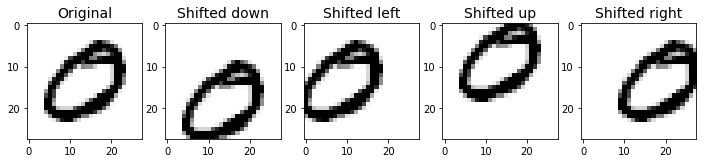

In [68]:
# Plotando digitos
plot_data_augmented(X_train)

In [71]:
# Treinando com o melhor modelo
sgd_final = grid_search.best_estimator_
sgd_final.fit(X_train_augmented, y_train_augmented)

# Realizando predições
y_pred = sgd_final.predict(X_test)
final_acc = accuracy_score(y_test, y_pred)

# Comunicando resultados
print(f'Acurácia final após o deslocamento de pixels: {final_acc:.4f}')

# Salvando resultados
dict_accs_sgd['acc_test_shifted'] = round(final_acc, 4)

C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Acurácia final após o deslocamento de pixels: 0.8532


Após a análise dos resultados, alguns levantamentos podem ser feitos:
    - SGD Classifier não é suscetível a overfitting (cross validation provou isso);
    - A padronização dos dados auxiliou no aumento da performance do modelo;
    - O hyperparameter tuning retornou uma combinação muito próximo do classificador padrão;
    - Não houve melhoria através do processo data augmentation (pelo contrário, houve piora).

In [74]:
# Transformando dados em dataset e salvando
dataset_accs = dataset_accs.append(dict_accs_sgd, ignore_index=True)

save_dataset(dataset_accs)
dataset_accs

,acc_train,acc_train_cv,acc_train_scaled,acc_test,acc_test_scaled,acc_test_grid,acc_test_shifted
0,1.0000,0.8617,0.8604,0.8800,0.6226,0.8890,0.9211
1,0.8825,0.8678,0.9101,0.8841,0.9139,0.9139,0.8532


## Random Forest

As Florestas Aleatórias "é" um algoritmo famoso e muito utilizado em diversos problemas. [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [75]:
# Preparando dados
X_train, y_train, X_test, y_test = prepare_mnist()

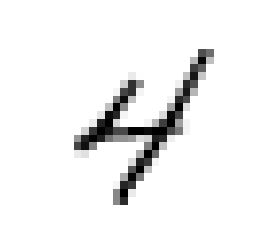

In [76]:
# Visualizando dígitos
plot_mnist(X_train)

In [77]:
# Lendo dataset de resultados até o momento
dataset_accs = load_dataset()
dataset_accs

,acc_train,acc_train_cv,acc_train_scaled,acc_test,acc_test_scaled,acc_test_grid,acc_test_shifted
0,1.0000,0.8617,0.8604,0.8800,0.6226,0.8890,0.9211
1,0.8825,0.8678,0.9101,0.8841,0.9139,0.9139,0.8532


Lembrando que:
    - 0: Decision Trees
    - 1: SGD Classifier

In [78]:
# Criando dicionario vazio para armazenar performances
dict_accs_forest = {}

### Dados de Treino

In [79]:
# Criando classificador
forest = RandomForestClassifier()

# Treinando modelo e avaliando performance
forest.fit(X_train, y_train)
train_pred = forest.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)

# Comunicando resultados
print(f'Acurácia do modelo Random Forest com os dados de treino: {train_acc:.4f}')

# Salvando resultados
dict_accs_forest['acc_train'] = round(train_acc, 4)

Acurácia do modelo Random Forest com os dados de treino: 0.9994


Como o modelo ```Decision Trees``` é extremamente suscetível a overfitting, também o modelo ```Random Forest``` pode ser. A própria acurácia obtida nos dados de treinamento é um grande indício disso. Mais uma vez, para verificar tal teste, será usado o ```cross validation```.

In [80]:
# Aplicando validação cruzada
forest_scores = cross_val_score(forest, X_train, y_train,
                               cv=3, scoring='accuracy')
display_scores(forest_scores)

# Salvando resultados
dict_accs_forest['acc_train_cv'] = round(forest_scores.mean(), 4)

Scores: [0.94121176 0.94054703 0.94184128]
Média: 0.9412
Desvio Padrão: 0.0005


A queda da acurácia com a validação cruzada comprova que ```Random Forest``` tem tendências ao overfitting. Porém, com a queda menos acentuada que no modelo ```Decision Trees``` é possível prever que os resultados finais serão mais animadores.

### Tunando Hiperparâmetros